# Preprocessing

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [3]:
# drop columns
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [4]:
# scale diameters 
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

# Ordinal Encode
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [5]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [6]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [7]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [8]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [9]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

# Logistic Regression Model

Motivation: The main reason I want to use logistic regression model with multiple classes is to set a reference for all other more complicated models to better evaluate their performances as logistic regression is the simplest one.

Metrics:
Average Recall

Hyperparameters tuning:
penalty: l1, l2, elasticnet (solver = saga)

class_weight: balanced or default

multi_class: multinomial (solver = saga), ovr (solver = liblinear)

l1_ratio: 0.2, 0.4, 0.6, 0.8

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
# Hyperparameters
penalty = ['l1', 'l2', 'elasticnet']
class_weight = ['balanced','']
multi_class = ['multinomial', 'ovr']
l1_ratio = [0.2, 0.4, 0.6, 0.8]

In [12]:
# function to fit and tune the model
def logReg(x_train, y_train, x_val, y_val, penalty, weight, multi, l1_ratio):

    target_names = ['Poor', 'Fair', 'Good']
    report = {}

    # when multi_class == 'ovr', the solver must be liblinear.
    # liblinear only support l1 and l2 penalty, and l1 doesn't work on my laptop
    model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    report["l2, balanced, ovr"] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    model = LogisticRegression(penalty='l2', class_weight='', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    report["l2, , ovr"] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    for i in penalty:
        for j in weight:
            tracker = 0
            if i != 'elasticnet':
                model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga')
            else:
                while tracker != len(l1_ratio):
                    model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga',l1_ratio=l1_ratio[tracker])
                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_val)
                    label = i + ", " + j + ", multinomial, " + str(l1_ratio[tracker])
                    report[label] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)
                    tracker += 1
                continue

            model.fit(x_train, y_train)
            y_pred = model.predict(x_val)
            label = i + ", " + j + ", multinomial"
            report[label] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    return report


In [13]:
# function to evaluate the model
def model_result(report):
    best_recall = 0
    best_accuracy = 0
    for params, metrics in report.items():
        # weighted recall on validation set
        avg_recall = metrics['macro avg']['recall']
        # accuracy on validation set
        accuracy = metrics['accuracy']
        
        if best_recall < avg_recall:
            best_recall = avg_recall
            best_params_recall = params
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_params_accuracy = params
    
    print("accuracy as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_accuracy)
    print("Optimal accuracy score: ", best_accuracy)

    print()
    print("macro recall as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_recall)
    print("Optimal macro recall score: ", best_recall)

    

In [14]:
# random stratified sampling
report_random = logReg(x_train, y_train, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_random)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='elasticnet', class_weight='balanced', multi_class='multinomial', l1_ratio = 0.8, solver='saga')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, , ovr
Optimal accuracy score:  0.8110265649557251

macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, multinomial
Optimal macro recall score:  0.415047382218037
Average recall on test dataset:  0.3984811574334959


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
# Over sampling
report_ros = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_ros)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l1', class_weight='balanced', multi_class='multinomial', solver='saga')
model.fit(x_ros, y_ros)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.5042645762257063

macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal macro recall score:  0.42276642069600673
Average recall on test dataset:  0.4194198721041554


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
# Under sampling
report_rus = logReg(x_rus, y_rus, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_rus)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', solver='liblinear')
model.fit(x_ros, y_ros)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.4995208341319431

macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.42272145507707476
Average recall on test dataset:  0.41864337836668425


In [18]:
## SMOTE on train data
report_smote = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_smote)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l1', class_weight='balanced', multi_class='multinomial', solver='saga')
model.fit(x_smote, y_smote)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.5042645762257063

macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal macro recall score:  0.42276642069600673
Average recall on test dataset:  0.41976722060899146


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


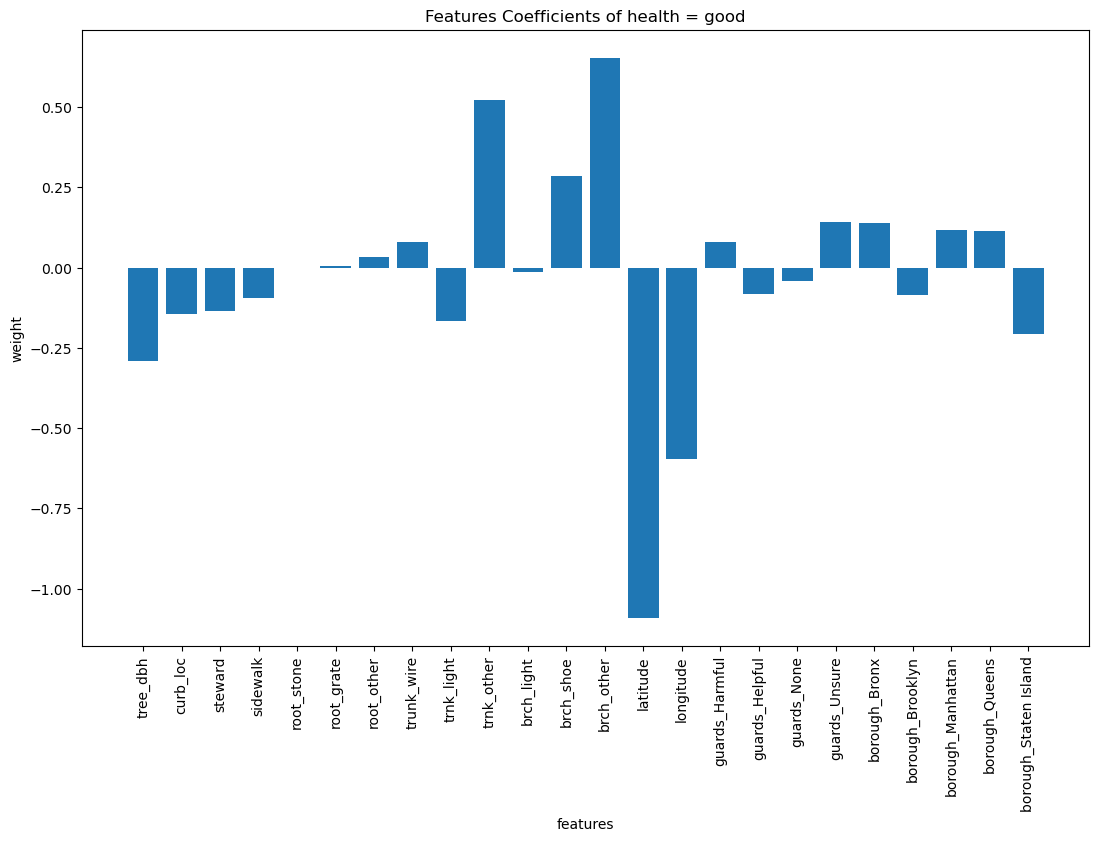

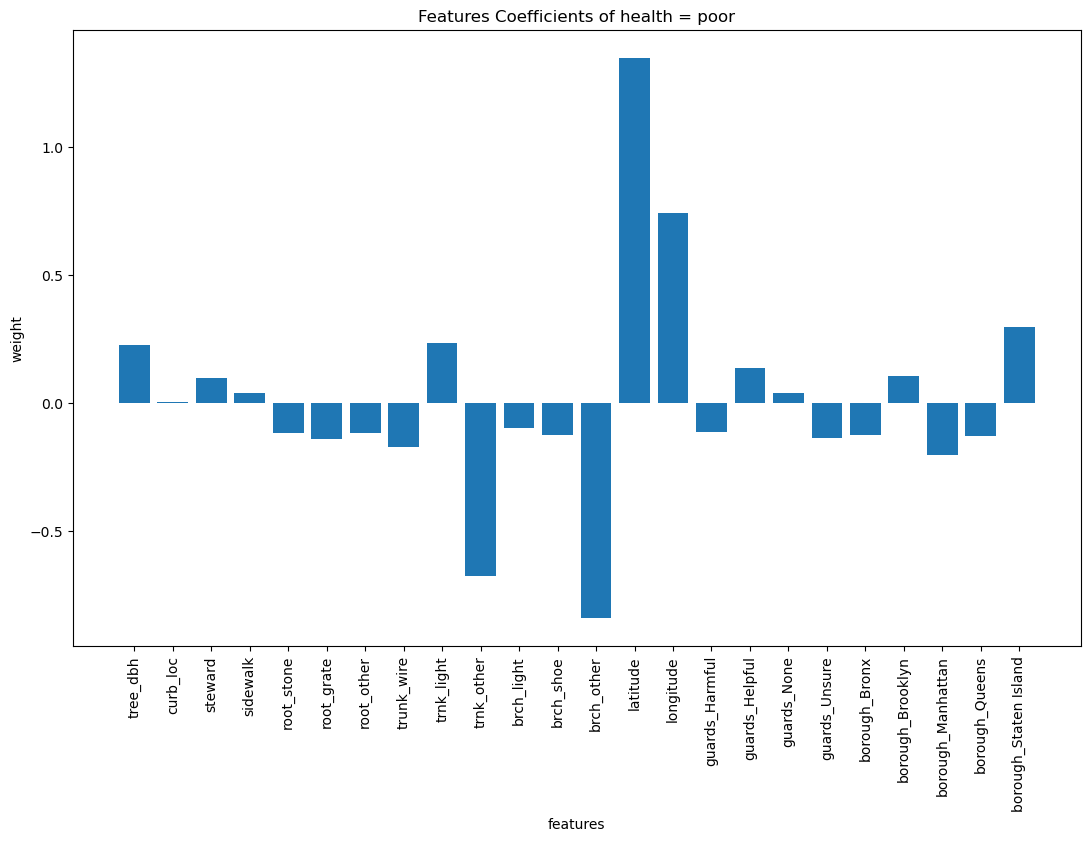

In [36]:
# Features importance analysis
# Best Model is using SMOTE sampling
# Features Coefficients of health = good
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=model.coef_[0])
plt.title("Features Coefficients of health = good")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()

# Features Coefficients of health = poor
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=model.coef_[2])
plt.title("Features Coefficients of health = poor")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()

